In [2]:
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
df=pd.read_csv('datasets/US_graduates/US_graduates.csv')

Question 1: To derive job satisfaction from our dataset, we calculate probabilities for different employment statuses and reasons within each major. By determining the likelihood of individuals being employed, unemployed, or working outside their field due to reasons like "Career Change" or "No Job Available," we can create a satisfaction profile. High satisfaction is assigned where the probability of employment in chosen roles is high, moderate satisfaction where there’s a significant rate of "Career Change," and low satisfaction when unemployment or working out of necessity is common. This method provides a `Satisfaction_Label` based on observed employment trends and job alignment within each major.

In [4]:
q1_df=df.copy()
q1_df['Total_Employment'] = q1_df[['Employment.Status.Employed', 'Employment.Status.Unemployed', 'Employment.Status.Not in Labor Force']].sum(axis=1)


q1_df['P_Employed'] = q1_df['Employment.Status.Employed'] / q1_df['Total_Employment']
q1_df['P_Career_Change'] = q1_df['Employment.Reason Working Outside Field.Career Change'] / q1_df['Total_Employment']
q1_df['P_No_Job_Available'] = q1_df['Employment.Reason Working Outside Field.No Job Available'] / q1_df['Total_Employment']

conditions = [
    (q1_df['P_Employed'] > 0.7) & (q1_df['P_Career_Change'] < 0.1),
    (q1_df['P_Employed'] > 0.5) & (q1_df['P_Career_Change'] >= 0.1),
    (q1_df['P_No_Job_Available'] > 0.2)
]
choices = ['Happy', 'Satisfied', 'Not Satisfied']

q1_df['Satisfaction_Label'] = np.select(conditions, choices, default='Unknown')


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree



Accuracy: 0.9903846153846154
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      0.90      0.95        10
           2       0.98      1.00      0.99        58

    accuracy                           0.99       104
   macro avg       0.99      0.97      0.98       104
weighted avg       0.99      0.99      0.99       104


Confusion Matrix:
 [[36  0  0]
 [ 0  9  1]
 [ 0  0 58]]


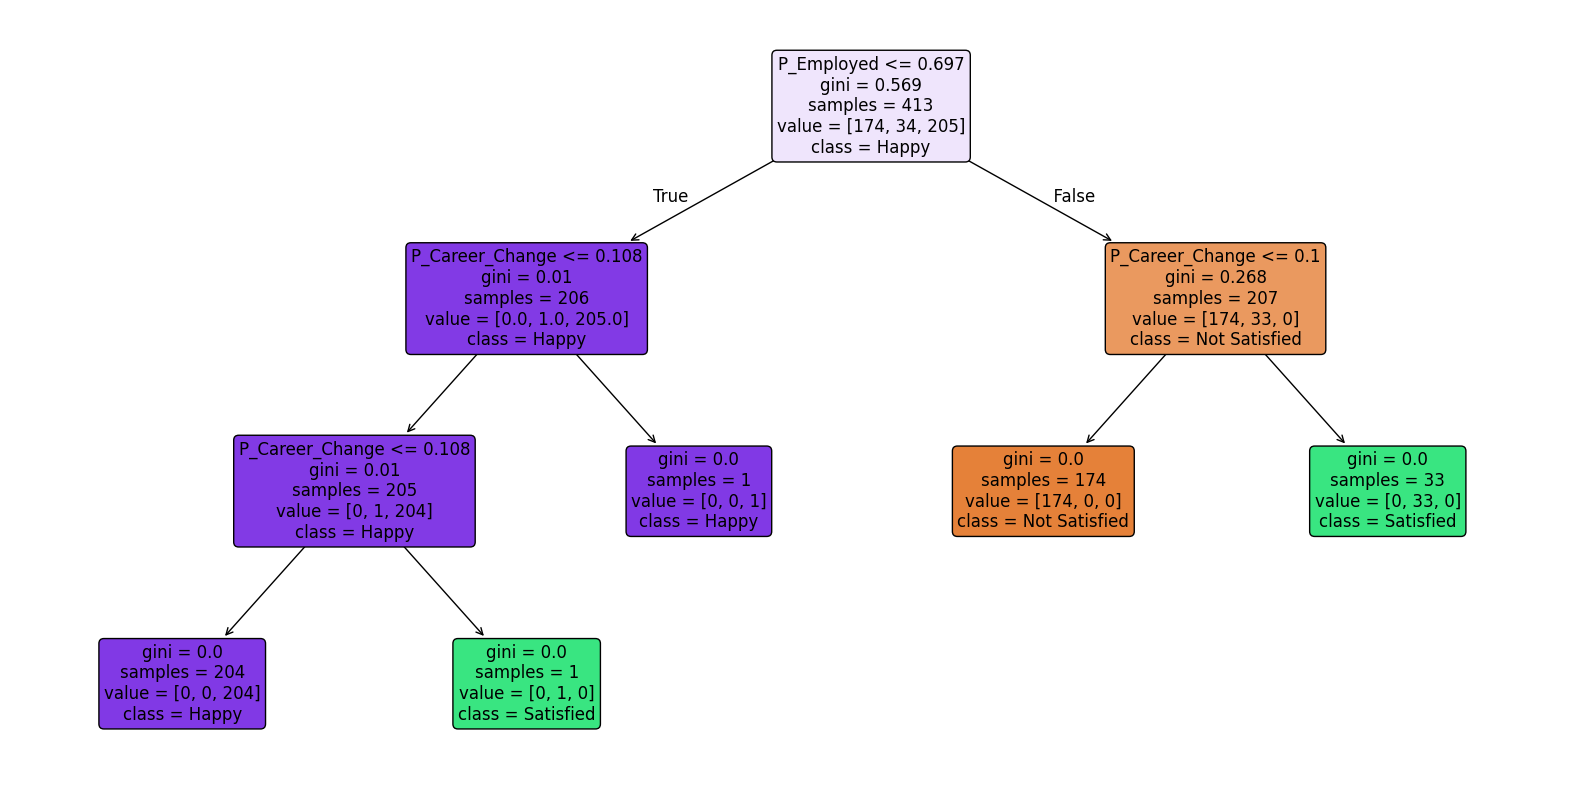

In [6]:
from sklearn.metrics import confusion_matrix

categorical_cols = q1_df.select_dtypes(include=['object']).columns


for col in categorical_cols:
    le = LabelEncoder()
    q1_df[col] = le.fit_transform(q1_df[col])


q1_df['Satisfaction_Label_Encoded'] = LabelEncoder().fit_transform(q1_df['Satisfaction_Label'])

X = q1_df.drop(columns=['Satisfaction_Label', 'Satisfaction_Label_Encoded'])  # drop target columns
y = q1_df['Satisfaction_Label_Encoded']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)


y_pred = dt_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
conf_matrix=confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

plt.figure(figsize=(20, 10))  # Adjust size for better clarity
plot_tree(dt_model, filled=True, feature_names=X.columns, class_names=['Not Satisfied', 'Satisfied', 'Happy'], rounded=True, fontsize=12)
plt.show()


The Decision Tree model achieved impressive results with an accuracy of 99.04%, accurately classifying nearly all test samples. The classification report indicates high precision, recall, and F1-scores across all satisfaction levels: "Not Satisfied," "Satisfied," and "Happy." Specifically, "Not Satisfied" and "Happy" were classified perfectly, while "Satisfied" had a single misclassification, with one instance labeled as "Happy." The confusion matrix supports these findings, as nearly all predictions fall along the diagonal, showing the model's effectiveness in capturing patterns in the data.
Since the data contained information about total number of people who took a specific major (coarse data), I decided to use probabilities to classify the Jobs after a specific major into the 3 labels. This approach will be correct as it takes into account the difference between the number of people who took each major as well as the number of people who still work in the same field.

The Decision Tree is well-suited for this dataset due to its interpretability, offering a clear visual structure that shows how features like employment and career change influence satisfaction levels. This model is also practical as it handles mixed data types without extensive preprocessing, making it easier to implement. Additionally, Decision Trees can capture non-linear relationships, which likely exist within real-world satisfaction data. Overall, this makes the Decision Tree an effective, interpretable, and efficient model choice for this classification task.

Question 2: Given an individual's educational major and other demographic factors, it is possible to predict their expected salary range or employment status.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [8]:
df['Salary_Range'] = pd.cut(df['Salaries.Mean'], bins=[-np.inf, 50000, 100000, np.inf], labels=[0, 1, 2])   
X = df.drop(['Salaries.Mean', 'Salary_Range', 'Employment.Status.Employed','Employment.Status.Unemployed','Employment.Status.Not in Labor Force'], axis=1)
y = df['Salary_Range']
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=32)
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

C:\Users\athar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5781 - loss: 0.8907 - val_accuracy: 0.7500 - val_loss: 0.6275
Epoch 2/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6777 - loss: 0.7114 - val_accuracy: 0.7692 - val_loss: 0.5204
Epoch 3/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7150 - loss: 0.6149 - val_accuracy: 0.8269 - val_loss: 0.4467
Epoch 4/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7471 - loss: 0.5607 - val_accuracy: 0.9038 - val_loss: 0.3829
Epoch 5/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7825 - loss: 0.4805 - val_accuracy: 0.8846 - val_loss: 0.3375
Epoch 6/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7988 - loss: 0.4702 - val_accuracy: 0.8942 - val_loss: 0.2923
Epoch 7/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8646 - loss: 0.3702 - val_accuracy: 0.9231 - val_loss: 0.2552
Epoch 8/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8941 - loss: 0.3471 - val_accuracy: 0.9231 - 

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3297e-04 - val_accuracy: 0.9519 - val_loss: 0.7417
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.0071 - val_accuracy: 0.9423 - val_loss: 0.7885
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0040 - val_accuracy: 0.9423 - val_loss: 0.7608
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9519 - val_loss: 0.7444
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9957 - loss: 0.0043 - val_accuracy: 0.9519 - val_loss: 0.7498
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.2510e-04 - val_accuracy: 0.9423 - val_loss: 0.7971
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.6905e-04 - val_accuracy: 0.9423 - val_loss: 0.8141
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.7439e-04 - val_accuracy: 0.

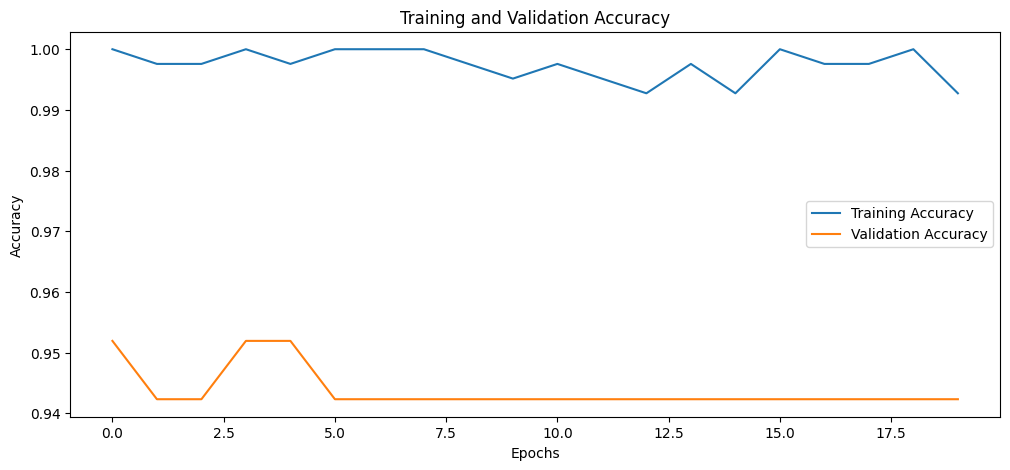

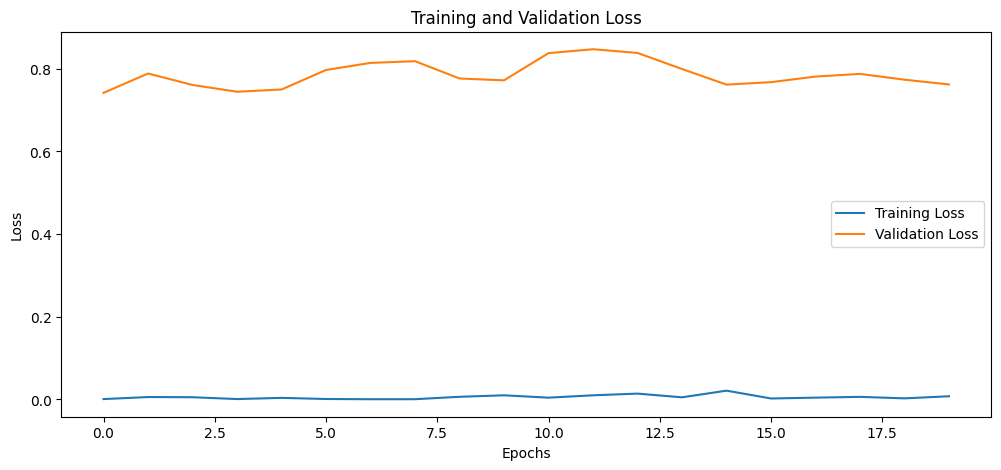

In [9]:
import matplotlib.pyplot as plt

# Assuming you have a history object from model.fit()
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Plotting Accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plotting Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Training and Validation Accuracy Plot: This plot shows that the training accuracy quickly reaches nearly 100%, while validation accuracy stabilizes around 94-95%. This indicates potential overfitting, as the model performs better on the training data than on the validation set

Training and Validation Loss Plot: The training loss remains very low, while the validation loss is significantly higher and slowly increases. This suggests that the model may be overfitting, as it fits the training data well but generalizes less effectively to new data.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


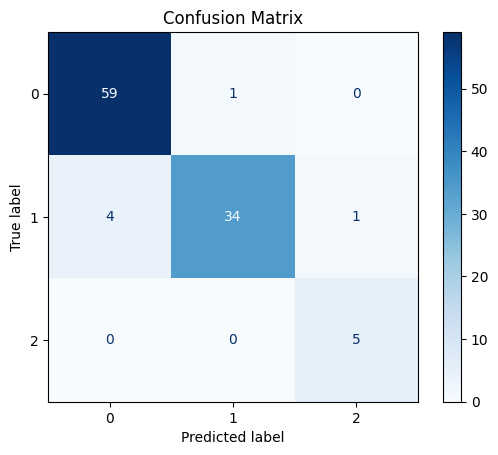

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicting on test data
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)  # For multi-class classification
y_test_classes = y_test.argmax(axis=1)  # True labels in categorical form

# Generating Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
ConfusionMatrixDisplay(conf_matrix).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


Confusion Matrix: The matrix shows the model's classification performance, with the majority of predictions along the diagonal, indicating correct classifications. A few misclassifications occur, primarily in classifying "Medium well payed" and "Low pay".

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


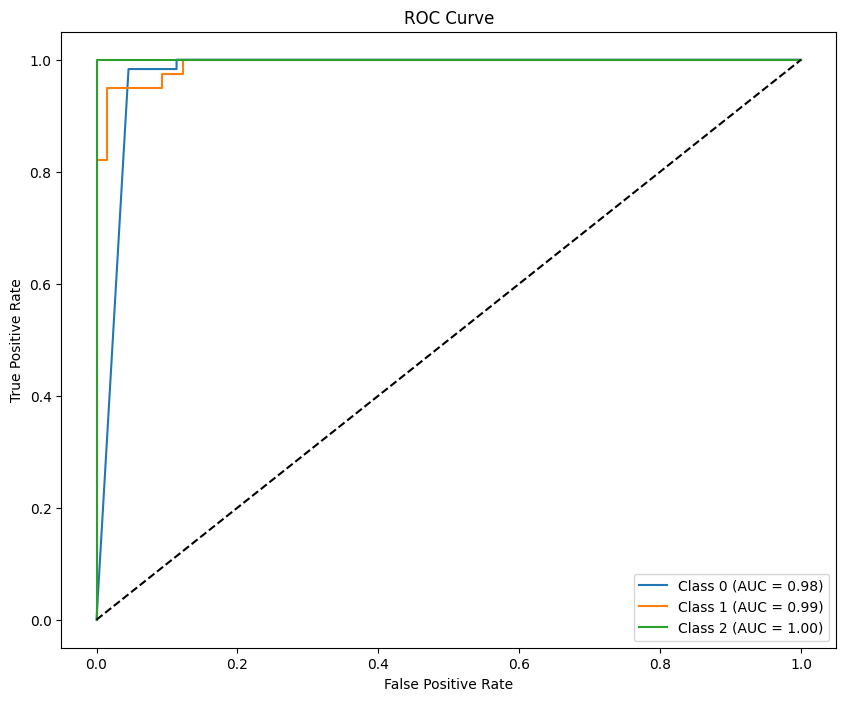

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


# Binarize the labels for multi-class ROC
y_test_bin = label_binarize(y_test_classes, classes=[0, 1, 2])  # Adjust classes as needed
y_pred_bin = model.predict(X_test)

# Plot ROC for each class
plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

ROC Curve: The ROC curves for each class show high performance, with AUC values close to 1.0, indicating that the model is effective at distinguishing between the classes.

The problem involves classifying jobs into categories of "High," "Medium," and "Low" pay based on various features. The neural network model performed well, achieving high accuracy with strong class separation, though some overfitting is indicated by a higher validation loss compared to training loss. Despite minor misclassifications, the model effectively distinguishes between pay categories, as shown by high AUC scores across all classes.

Justification for using Neural Networks:
Neural networks are ideal for this problem due to their ability to learn complex, non-linear relationships and model interactions between features automatically. While the current results show that only a few features (like Satisfaction_Label_Encoded and P_Career_Change) are influential, the neural network can still uncover hidden patterns with further training or hyperparameter tuning. Additionally, neural networks are scalable and can handle large, high-dimensional datasets, making them a good choice for future improvements or more complex datasets. Despite the current feature importance, the model's flexibility suggests it can adapt to and improve with more optimization.